In [72]:
from pandas.core.frame import DataFrame
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
import re


data: DataFrame = pd.read_csv("SecondHand_Cars_dataset_2025-06-25.csv", low_memory=False)


In [73]:
# bereinigung
# Beispiel für CO₂-Emissionen
from pandas.core.frame import DataFrame


data['CO₂-Emissionen'] = data['CO₂-Emissionen'].str.extract(r'(\d+\.?\d*)').astype(float)

# Beispiel für Hubraum
data['Hubraum'] = data['Hubraum'].str.replace(' cm³', '', regex=False).astype(float)

# Leistung (z.B. "55 kW (75 PS)")
data['Leistung_kW'] = data['Leistung'].str.extract(r'(\d+)\s*kW').astype(float)

# Leere Strings durch NaN ersetzen (falls nötig)
data.replace("", pd.NA, inplace=True)

# Nur boolesche Spalten ermitteln (mind. ein True/Falscher Wert enthalten)
bool_columns = [col for col in data.columns if data[col].dropna().isin([True, False]).all()]

# Nur in diesen Spalten NaN durch False ersetzen
data[bool_columns] = data[bool_columns].fillna(False)


dummies: DataFrame = pd.get_dummies(data[["Verkaufsart", "Karosserieform", "Fahrzeugart", "Antriebsart", "Länderversion", "HU"]], drop_first=True)

data: DataFrame = pd.concat([data, dummies], ignore_index=True)

bool_cols = data.select_dtypes(include=["bool"]).columns
data[bool_cols] = data[bool_cols].astype(int)

bool_map = {"True": 1, "False": 0, "Ja": 1, "Nein": 0, "true": 1, "false": 0}
data = data.replace(bool_map)

# Beispiel: 'Kilometerstand' = "108.138 km" → 108138
data['Kilometerstand'] = (
    data['Kilometerstand']
    .astype(str)                      # sicherstellen, dass es Strings sind
    .str.replace('.', '', regex=False)  # Tausenderpunkt entfernen
    .str.replace(' km', '', regex=False)  # " km" entfernen
    .str.strip()                      # Leerzeichen entfernen
    .replace('', pd.NA)              # leere Strings in NaN umwandeln
    .astype('float')                 # in float (oder int) umwandeln
)

# Jahr + (Monat-1)/12 → ergibt z. B. 2015.75 für Oktober 2015
def parse_datum(value):
    try:
        monat, jahr = map(int, str(value).split('/'))
        return jahr + (monat - 1) / 12
    except:
        return np.nan  # statt pd.NA

data['Erstzulassung_num'] = data['Erstzulassung'].apply(parse_datum).astype(float)
data['Letzte Inspektion'] = data['Letzte Inspektion'].apply(parse_datum).astype(float)



/tmp/ipykernel_6014/3854111228.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[bool_columns] = data[bool_columns].fillna(False)
/tmp/ipykernel_6014/3854111228.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(bool_map)


<Axes: >

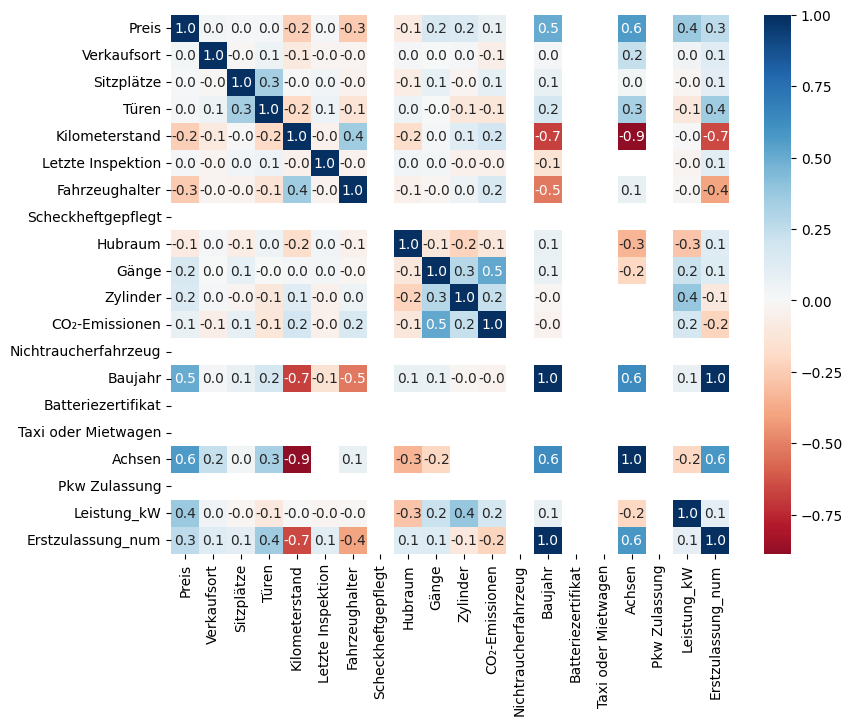

In [74]:
corr = data.corr(numeric_only=True)
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)
sns.heatmap(corr, annot=True, fmt='.1f', cmap='RdBu', center=0, ax=ax)